# Image Classification Task

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,TensorBoard
from tensorflow.keras.optimizers import SGD,Adam

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

## Load Data into model and resize, check = true, to view images

In [2]:
labels = ['colon','endometrium_1','endometrium_2','kidney' , 'liver', 'lung','lymph_node','pancreas','skin_2','small_intestine','spleen']

train_path ='C:/Users/mohap/Desktop/RATask/data-20211216T181612Z-006/data/train'
test_path ='C:/Users/mohap/Desktop/RATask/data-20211216T181612Z-006/data/test'
IMG_SIZE = 600
color = 3
check = False
if check == True:
    for label in labels:
        path = os.path.join(train_path,label) #path to organ tissue
        for img in os.listdir(path):
            if color == 1:
                #grayscale
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                plt.imshow(img_array, cmap='gray')
            else:
                img_array = cv2.imread(os.path.join(path,img))
                plt.imshow(img_array)
            plt.show()
            img_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            plt.imshow(img_array)
            plt.show()
            break

In [3]:
training_data = []
testing_data = []
def create_training():
    for label in labels:
        class_num = labels.index(label)
        path = os.path.join(train_path,label) #path to organ tissue
        for img in os.listdir(path):
            if color == 1:
                #grayscale
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                
            else:
                img_array = cv2.imread(os.path.join(path,img))
                
            img_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            training_data.append([img_array,class_num])
def create_testing():
    for label in labels:
        class_num = labels.index(label)
        path = os.path.join(test_path,label) #path to organ tissue
        for img in os.listdir(path):
            if color == 1:
                #grayscale
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                
            else:
                img_array = cv2.imread(os.path.join(path,img))
                
            img_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            testing_data.append([img_array,class_num])
create_training()   
create_testing()  


In [4]:
for sample in training_data:
    if check == True: print(sample[1])

X = []
Y = []

for features,label in training_data:
    X.append(features); Y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, color)
# X = X/255.0

print(X.shape[1:])

#create multinomial classes
from tensorflow.keras.utils import to_categorical
y = to_categorical(Y)

(600, 600, 3)


## Data Preprocessing and Augmentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator# Create Image Data Generator for Train Set

labels = ['colon','endometrium_1','endometrium_2','kidney' , 'liver', 'lung','lymph_node','pancreas','skin_2','small_intestine','spleen']

train_path ='C:/Users/mohap/Desktop/RATask/data-20211216T181612Z-006/data/train'
test_path ='C:/Users/mohap/Desktop/RATask/data-20211216T181612Z-006/data/test'
IMG_SIZE = 600

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

#preprocessing_function=add_noise
image_gen = ImageDataGenerator(rescale = 1./255,
                               validation_split=0.2,
                            rotation_range=30
                             )# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

batch_size = 10

train = image_gen.flow_from_directory(
      train_path,
     class_mode='sparse', shuffle=False,
      batch_size=batch_size,
      subset='training',
      target_size=(IMG_SIZE,IMG_SIZE),
      )

val = image_gen.flow_from_directory(
      train_path,
     class_mode='sparse', shuffle=False,
      batch_size=batch_size,
      subset='validation',
      target_size=(IMG_SIZE,IMG_SIZE),
      )

test = test_data_gen.flow_from_directory(
      test_path, 
    class_mode='sparse',
      target_size=(IMG_SIZE,IMG_SIZE),
      shuffle=False,
      )

check = False
if check == True:
    i = 0
    for batch in image_gen.flow(X, batch_size=2,
                              save_to_dir='C:/Users/mohap/Desktop/RATask/generated', save_prefix='augmented', save_format='jpeg'):
        i += 1
        if i > 20:
            break  

Found 53 images belonging to 11 classes.
Found 7 images belonging to 11 classes.
Found 41 images belonging to 11 classes.


In [6]:
print(train.image_shape)

(600, 600, 3)


# Baseline Models

In [7]:
#Convolution -> Pooling -> Convolution -> Pooling
def giveModel(number):
    model = Sequential()
    if number == 1:
        
        #64 nodes window_size = 3x3 
        model.add( Conv2D(64, (3,3), input_shape = list(train.image_shape)) )#shhape of features exluding number of features
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))

        model.add(Conv2D(64, (3,3)))#shhape of features exluding number of features
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2,2)))

        model.add(Flatten())#last fully connected
        model.add(Dense(64))
        model.add(Activation("relu"))

        model.add(Dense(len(labels)))
        model.add(Activation('softmax'))

    elif number == 2:
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=list(train.image_shape)))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(len(labels), activation='softmax'))

    elif number == 3: 
        model.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=list(train.image_shape)))
        model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
        model.add(Conv2D(64, kernel_size=5, activation='relu'))
        model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(Dense(len(labels),activation='softmax'))

    return model



Training

In [8]:
path = 'C:\\Users\\mohap\\Desktop\\RATask\\logs'
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)#stop if no improvemnt for 3 epochs
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience = 2, verbose=1,factor=0.1, min_lr=0.000001)#reduce learning rate as we reach optimum point
tensorboard = TensorBoard(log_dir=path + 'baseline')
#tensorboard --logdir=logs/ --command to view training graphs

callbacks_list = [tensorboard]

from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes),train.classes)
cw = dict(zip( np.unique(train.classes), weights))

model = giveModel(3)
#SGD(lr=0.01, momentum=0.9)
#Adam(lr = 0.01, decay = 1e-6)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = 'adam', metrics=['accuracy'])
#, callbacks=callbacks_list
#pass in batch size and epochs
model.fit(train, epochs = 50,validation_data=val, callbacks=callbacks_list) #you can validation_split for more data


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/50
6/6 [==============================] - 82s 14s/step - loss: 111.1792 - acc: 0.3585 - val_loss: 18.3835 - val_acc: 0.0000e+00
Epoch 2/50
6/6 [==============================] - 74s 12s/step - loss: 5.9086 - acc: 0.0000e+00 - val_loss: 2.3952 - val_acc: 0.2857
Epoch 3/50
6/6 [==============================] - 70s 12s/step - loss: 2.3955 - acc: 0.2453 - val_loss: 2.3902 - val_acc: 0.2857
Epoch 4/50
6/6 [==============================] - 71s 12s/step - loss: 2.3922 - acc: 0.2264 - val_loss: 2.3835 - val_acc: 0.2857
Epoch 5/50
6/6 [==============================] - 71s 12s/step - loss: 2.3874 - acc: 0.1509 - val_loss: 2.3756 - val_acc: 0.5714
Epoch 6/50
6/6 [==============================] - 71s 12s/step - loss: 2.3821 - acc: 0.3396 - val_loss: 2.3673 - val_acc: 0.5714
Epoch 7/50
6/6 [==============================] - 70s 12s/step - loss: 2.3765 - acc: 0.3396 - val

In [9]:
raw_cnn_test_accu = model.evaluate(test,verbose=1)
print('The testing accuracy is :',raw_cnn_test_accu[1]*100, '%')


2/2 [==============================] - 11s 5s/step - loss: 2.5596 - acc: 0.0244
The testing accuracy is : 2.4390242993831635 %


In [11]:
X = []
Y = []

for features,label in training_data:
    X.append(features); Y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, color)
X = X/255.0
#y=  model.predict(X)
yclasess = model.predict_classes(X)

In [12]:
print(yclasess)

[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


In [13]:
raw_cnn_test_accu

[2.5596240758895874, 0.024390243]

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 594, 594, 128)     18944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 296, 296, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 292, 292, 64)      204864    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 145, 145, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1345600)           0         
_________________________________________________________________
dense (Dense)                (None, 128)               172236928 
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1

# Transfer Learning

# VGG16

In [15]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model, layers
vgg16_model = VGG16(pooling='max', weights='imagenet', include_top=False, input_shape=list(train.image_shape))
for layers in vgg16_model.layers:
            layers.trainable=False

last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(len(labels), activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)

vgg16_final_model.compile(loss = 'sparse_categorical_crossentropy', optimizer= 'adam', metrics=['acc'])


In [18]:
vgg_early_stopping = EarlyStopping(monitor='loss', patience=5)
tensorboard = TensorBoard(log_dir=path + 'vgg')

vgg16_final_model.fit(train, epochs = 50 ,validation_data = val,verbose=1,callbacks=[tensorboard,vgg_early_stopping])

Epoch 1/50
6/6 [==============================] - 46s 8s/step - loss: 3.7804 - acc: 0.2264 - val_loss: 1.6025 - val_acc: 0.5714
Epoch 2/50
6/6 [==============================] - 45s 8s/step - loss: 2.8535 - acc: 0.3208 - val_loss: 1.7392 - val_acc: 0.5714
Epoch 3/50
6/6 [==============================] - 46s 8s/step - loss: 2.1856 - acc: 0.2075 - val_loss: 2.2348 - val_acc: 0.0000e+00
Epoch 4/50
6/6 [==============================] - 46s 8s/step - loss: 2.0421 - acc: 0.3019 - val_loss: 1.7350 - val_acc: 0.2857
Epoch 5/50
6/6 [==============================] - 45s 8s/step - loss: 1.7505 - acc: 0.4340 - val_loss: 1.4137 - val_acc: 0.5714
Epoch 6/50
6/6 [==============================] - 46s 8s/step - loss: 1.6890 - acc: 0.4906 - val_loss: 1.2134 - val_acc: 0.5714
Epoch 7/50
6/6 [==============================] - 46s 8s/step - loss: 1.5831 - acc: 0.4528 - val_loss: 1.2725 - val_acc: 0.5714
Epoch 8/50
6/6 [==============================] - 46s 8s/step - loss: 1.4686 - acc: 0.5849 - val_los

In [19]:
vgg_test_accu = vgg16_final_model.evaluate(test,verbose=1)
print('The testing accuracy is :',vgg_test_accu[1]*100, '%')

2/2 [==============================] - 34s 17s/step - loss: 1.8274 - acc: 0.3902
The testing accuracy is : 39.024388790130615 %


In [20]:
yclasses = vgg16_final_model.predict(X)
for i in yclasses:
    curr = list(i)
    print(curr.index(max(curr)))

0
0
1
1
1
6
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
6
2
5
5
5
5
5
6
10
10
6
6
6
6
6
6
6
6
6
6
6
6
10
6
6
10
6
6
6
6
8
2
8
3
6
10
10
10


# ResNet50

In [21]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import Model, layers

ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=list(train.image_shape), classes=11)

for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(len(labels),activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'sparse_categorical_crossentropy', optimizer= opt, metrics=['acc'])



C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [23]:
resnet_early_stopping = EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
tensorboard = TensorBoard(log_dir=path + 'resnet')


callbacklist = [tensorboard,resnet_early_stopping,reduce_lr]

resnet50_x_final_model.fit(train, epochs = 25 ,validation_data = val,callbacks=callbacklist,verbose=1)

Epoch 1/25
6/6 [==============================] - 337s 56s/step - loss: 41.1307 - acc: 0.1509 - val_loss: 2.3367 - val_acc: 0.5714
Epoch 2/25
6/6 [==============================] - 336s 56s/step - loss: 2.3688 - acc: 0.3396 - val_loss: 452507285323776.0000 - val_acc: 0.5714
Epoch 3/25
6/6 [==============================] - 333s 56s/step - loss: 2.3521 - acc: 0.3396 - val_loss: 4095245287424.0000 - val_acc: 0.5714
Epoch 4/25
6/6 [==============================] - 335s 56s/step - loss: 2.3375 - acc: 0.3396 - val_loss: 91116068864.0000 - val_acc: 0.4286
Epoch 5/25
6/6 [==============================] - 336s 56s/step - loss: 2.3207 - acc: 0.3396 - val_loss: 4708865024.0000 - val_acc: 0.5714
Epoch 6/25
6/6 [==============================] - 336s 56s/step - loss: 2.3065 - acc: 0.3396 - val_loss: 309045248.0000 - val_acc: 0.5714
Epoch 7/25
6/6 [==============================] - 335s 56s/step - loss: 2.2929 - acc: 0.3396 - val_loss: 51410004.0000 - val_acc: 0.5714
Epoch 8/25
6/6 [=============

KeyboardInterrupt: 

In [24]:
resnet_test_accu = resnet50_x_final_model.evaluate(test,verbose=1)
print('The testing accuracy is :',resnet_test_accu[1]*100, '%')

2/2 [==============================] - 26s 13s/step - loss: 213.8433 - acc: 0.0244
The testing accuracy is : 2.4390242993831635 %


In [25]:
yclasses = resnet50_x_final_model.predict(X)
for i in yclasses:
    curr = list(i)
    print(curr.index(max(curr)))

6
6
6
6
6
6
10
6
6
6
6
6
6
6
10
6
6
6
6
6
6
6
6
10
10
10
10
10
10
6
6
6
6
10
6
6
6
6
6
6
6
10
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6


# InceptionV3

In [26]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model, layers

InceptionV3_model = InceptionV3(input_shape=list(train.image_shape),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
       layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
       layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(len(labels), activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [27]:
inception_early_stopping = EarlyStopping(monitor='loss', patience=5)
tensorboard = TensorBoard(log_dir=path + 'inception')
InceptionV3_x_final_model.fit(train, epochs = 25, validation_data = val,callbacks=[tensorboard,inception_early_stopping],verbose=1)

Epoch 1/25
6/6 [==============================] - 110s 18s/step - loss: 4.7216 - acc: 0.0377 - val_loss: 2.9525 - val_acc: 0.5714
Epoch 2/25
6/6 [==============================] - 79s 13s/step - loss: 2.8384 - acc: 0.3019 - val_loss: 1.1935 - val_acc: 0.7143
Epoch 3/25
6/6 [==============================] - 79s 13s/step - loss: 2.9227 - acc: 0.3962 - val_loss: 1.3987 - val_acc: 0.4286
Epoch 4/25
6/6 [==============================] - 81s 13s/step - loss: 1.3959 - acc: 0.5660 - val_loss: 2.4653 - val_acc: 0.0000e+00
Epoch 5/25
6/6 [==============================] - 77s 13s/step - loss: 1.0188 - acc: 0.7925 - val_loss: 1.5167 - val_acc: 0.5714
Epoch 6/25
6/6 [==============================] - 88s 15s/step - loss: 0.8721 - acc: 0.7736 - val_loss: 1.0341 - val_acc: 0.5714
Epoch 7/25
6/6 [==============================] - 80s 13s/step - loss: 0.6559 - acc: 0.8302 - val_loss: 1.7364 - val_acc: 0.4286
Epoch 8/25
6/6 [==============================] - 85s 14s/step - loss: 0.5553 - acc: 0.8302 

In [28]:
incep_test_accu = InceptionV3_x_final_model.evaluate(test,verbose=1)
print('The testing accuracy is :',incep_test_accu[1]*100, '%')

2/2 [==============================] - 20s 10s/step - loss: 2.4249 - acc: 0.1220
The testing accuracy is : 12.195122241973877 %


In [29]:
yclasses = InceptionV3_x_final_model.predict(X)
for i in yclasses:
    curr = list(i)
    print(curr.index(max(curr)))

0
0
1
1
6
6
2
2
8
8
2
2
2
2
2
6
8
2
2
3
2
6
4
8
5
5
5
5
5
6
6
6
0
6
8
6
6
10
10
6
8
6
6
6
4
2
2
6
6
6
6
2
8
8
8
6
4
2
6
10


# Summary

In [38]:
from tabulate import tabulate

mydata = [{"Raw CNN", raw_cnn_test_accu[1]},
          {"Inception_v3", incep_test_accu[1]}, 
          {"VGG16", vgg_test_accu[1]}, 
          {"resnet50", resnet_test_accu[1]}, ]

head = [ "Test Accuracy", "Model"]

print(tabulate(mydata, headers=head, tablefmt="grid"))

+-----------------+--------------+
|   Test Accuracy | Model        |
+=================+==============+
|       0.0243902 | Raw CNN      |
+-----------------+--------------+
|       0.121951  | Inception_v3 |
+-----------------+--------------+
|       0.390244  | VGG16        |
+-----------------+--------------+
|       0.0243902 | resnet50     |
+-----------------+--------------+


In [ ]:
vgg16_final_model.save('C:/Users/mohap/Desktop/RATask/model/vgg')

In [ ]:
model.save('C:/Users/mohap/Desktop/RATask/model/baseline')

In [ ]:
resnet50_x_final_model.save('C:/Users/mohap/Desktop/RATask/model/resnet')

In [ ]:
InceptionV3_x_final_model.save('C:/Users/mohap/Desktop/RATask/model/inception')

In [39]:
import pandas as pd

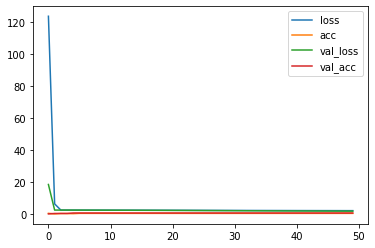

In [40]:
pd.DataFrame(model.history.history).plot()

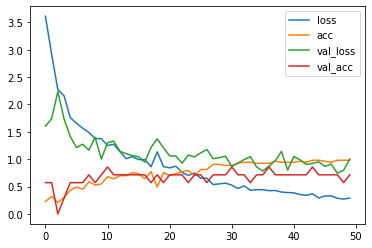

In [41]:
pd.DataFrame(vgg16_final_model.history.history).plot()

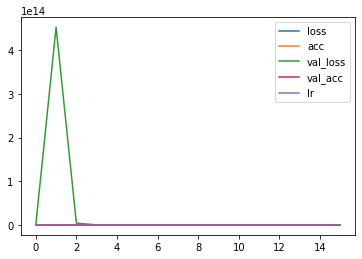

In [42]:
pd.DataFrame(resnet50_x_final_model.history.history).plot()

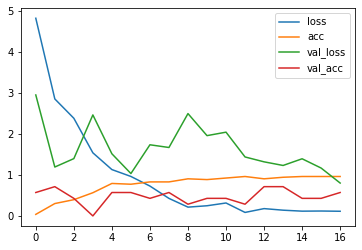

In [44]:
pd.DataFrame(InceptionV3_x_final_model.history.history).plot()